In [2]:
from scipy.io import loadmat

# Load the .mat file
data = loadmat('dat1.mat')

# Print the keys to inspect the contents
print("Keys:", data.keys())

# Access and squeeze the desired variable
d = data['dat1'].squeeze()

print("d shape:", d.shape)


Keys: dict_keys(['__header__', '__version__', '__globals__', 'dat1'])
d shape: (1024,)


In [3]:
dd = d.reshape(32, 32)
print("Reshaped d shape:", dd.shape)


Reshaped d shape: (32, 32)


In [4]:
# import numpy as np

# # Example: replace this with your actual 32x32 matrix
# dd = np.random.rand(32, 32)  # Random values between 0 and 1

# # Normalization to [3, 13]
# min_val = dd.min()
# max_val = dd.max()
# normalized_matrix = 3 + (dd - min_val) * (13 - 3) / (max_val - min_val)
import numpy as np

# Step 1: Normalize to [0, 1]
scaled = (dd - dd.min()) / (dd.max() - dd.min())

# Step 2: Apply gamma correction to preserve edges
gamma = 0.5  # Try 0.3 to 0.7 — lower values increase contrast
scaled = scaled**gamma

# Step 3: Rescale to [3, 13]
normalized_dd = 3 + scaled * 10


In [5]:
dd.max()

np.float64(212.99451212)

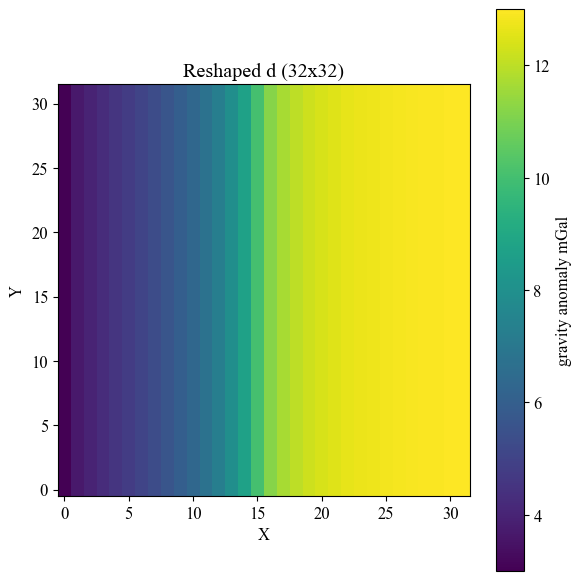

In [21]:
import matplotlib.pyplot as plt

# Assuming d_reshaped is already defined
plt.figure(figsize=(6, 6))
plt.imshow(normalized_dd, cmap='viridis', origin='lower')
plt.colorbar(label='gravity anomaly mGal')
plt.title('Reshaped d (32x32)')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()


In [7]:
import torch
import torch.nn as nn
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
from collections import Counter
from sklearn.metrics import f1_score
import torch.nn.functional as F
import time
import h5py
import seaborn as sns
plt.rc('font',family='Times New Roman', size=12)


In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,images,train=True, masks=None):
        self.train = train
        self.images = images
        if self.train:
            self.masks = masks
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)
    
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True),
                    nn.BatchNorm2d(out_channels),
                    nn.ELU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True),
                    nn.BatchNorm2d(out_channels),
                    nn.ELU(inplace=True))
        
    def forward(self, x):
        x = self.conv(x)
        return x     


class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
             
        self.double_conv1 = double_conv(1, start_fm, 3, 1, 1)
        self.maxpool1 = nn.Sequential(
                        nn.Conv2d(start_fm, start_fm, 2, 2, 0, bias=True),
                        nn.BatchNorm2d(start_fm),
                        nn.ELU(inplace=True))
        self.double_conv2 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
        self.maxpool2 = nn.Sequential(
                    nn.Conv2d(start_fm*2, start_fm*2, 2, 2, 0, bias=True),
                    nn.BatchNorm2d(start_fm*2),
                    nn.ELU(inplace=True))
        self.double_conv3 = double_conv(start_fm * 2, start_fm * 4, 3, 1, 1)
        self.maxpool3 = nn.Sequential(
                    nn.Conv2d(start_fm*4, start_fm*4, 2, 2, 0, bias=True),
                    nn.BatchNorm2d(start_fm*4),
                    nn.ELU(inplace=True))
        self.double_conv4 = double_conv(start_fm * 4, start_fm * 8, 3, 1, 1)
        self.maxpool4 = nn.Sequential(
                nn.Conv2d(start_fm*8, start_fm*8, 2, 2, 0, bias=True),
                nn.BatchNorm2d(start_fm*8),
                nn.ELU(inplace=True))
        self.double_conv5 = double_conv(start_fm * 8, start_fm * 16, 3, 1, 1)
        
        self.t_conv4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, 2, 2)
        self.ex_double_conv4 = double_conv(start_fm * 16, start_fm * 8, 3, 1, 1)
        self.t_conv3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, 2, 2)
        self.ex_double_conv3 = double_conv(start_fm * 8, start_fm * 4, 3, 1, 1)
        self.t_conv2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, 2, 2)
        self.ex_double_conv2 = double_conv(start_fm * 4, start_fm * 2, 3, 1, 1)
        self.t_conv1 = nn.ConvTranspose2d(start_fm * 2, start_fm, 2, 2)
        self.ex_double_conv1 = double_conv(start_fm * 2, start_fm, 3, 1, 1)
        self.ex_double_conv0 = double_conv(start_fm, 16, 3, 1, 1)
        self.final = nn.Sequential(
                    nn.Conv2d(16, 16, kernel_size=1, padding=0, bias=True),
                    nn.BatchNorm2d(16),
                    nn.Sigmoid())

        
    def forward(self, inputs):

        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)
        maxpool1 = nn.Dropout(0.20)(maxpool1)
        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)
        maxpool2 = nn.Dropout(0.20)(maxpool2)
        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)
        maxpool3 = nn.Dropout(0.20)(maxpool3)
        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
        maxpool4 = nn.Dropout(0.20)(maxpool4)
        conv5 = self.double_conv5(maxpool4)
        t_conv4 = self.t_conv4(conv5)
        t_conv4 = nn.Dropout(0.20)(t_conv4)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        ex_conv4 = self.ex_double_conv4(cat4)
        t_conv3 = self.t_conv3(ex_conv4)
        t_conv3 = nn.Dropout(0.20)(t_conv3)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)
        t_conv2 = self.t_conv2(ex_conv3)
        t_conv2 = nn.Dropout(0.20)(t_conv2)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        t_conv1 = self.t_conv1(ex_conv2)
        t_conv1 = nn.Dropout(0.20)(t_conv1)
        cat1 = torch.cat([conv1, t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        ex_conv0 = self.ex_double_conv0(ex_conv1)
        result = self.final(ex_conv0)   
        return result

In [9]:
def Model(m, w):
    L, W, H= m.shape
    c = ["#D1FEFE", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", "#D3F821", "#FFDE00", "#FF9D00", "#F03A00", "#E10000"]
    x, y, z = np.indices((L, W, H))
    model = (x < 0) & (y < 0) & (z < 0)
    color = np.empty(m.shape, dtype=object)
    for i in range(L):
        for j in range(W):
            for k in range(H):
                if m[i][j][k] >= w:
                    cube = (x > i-1) & (x <= i)& (y > j-1) & (y <= j) & (z > k-1) & (z <= k)
                    color[cube] = c[int(round(10*m[i][j][k]))-1]
                    model = model | cube
    plt_model(model, color)

def plt_model(model, facecolors='r'):
    fig = plt.figure(figsize = (8, 4))
    ax = fig.gca(projection='3d')
    ax.voxels(model, facecolors=facecolors, edgecolors='w', linewidth=0.4)
    plt.xticks(np.arange(0, 44, 1), ['-2725', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-2325', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-1925', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-1525', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-1125', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-725', ' ', ' ', ' '])
    ax.set_xlabel('Easting (m)', labelpad=3)
    plt.yticks(np.arange(0, 37, 1), ['-1175', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-775', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-375', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '25', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '425', ' ', ' ', ' ', ' '])
    ax.set_ylabel('Northing (m)', labelpad=2)
    ax.set_zticks(np.arange(0, 17, 1))
    ax.set_zticklabels(['0', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '800'])
    ax.set_zlabel('Depth (m)', labelpad=-2)
    ax.invert_zaxis()
    ax.xaxis.set_tick_params(pad=-2)
    ax.yaxis.set_tick_params(pad=-2)
    ax.zaxis.set_tick_params(pad=0)
    plt.show()
    
def colorma():
    cdict = ["#F2F2F2", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", "#D3F821", "#FFDE00", "#FF9D00", "#F03A00", "#E10000"] 
    return colors.ListedColormap(cdict, 'indexed')

def plot_xoz(model, index):
    plt.imshow(model.swapaxes(1, 2).T[index].T, cmap=colorma())
    plt.xticks(np.arange(-0.5, 43.5, 1), ['-2725', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-2325', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-1925', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-1525', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-1125', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-725', ' ', ' ', ' '])
    plt.xlabel('Easting (m)')
    plt.yticks(np.arange(-0.5, 16.5, 1), ['0', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '800'])
    plt.ylabel('Depth (m)')
    plt.grid()
    plt.tight_layout()

def plot_yoz(model, index):
    plt.imshow(model.T[index].T, cmap=colorma())
    plt.xticks(np.arange(-0.5, 36.5, 1), ['-1175', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-775', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-375', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '25', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '425', ' ', ' ', ' ', ' '])
    plt.xlabel('Northing (m)')
    plt.yticks(np.arange(-0.5, 16.5, 1), ['0', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '800'])
    plt.ylabel('Depth (m)')
    plt.grid()
    plt.tight_layout()
    
def plot_xoy(model, index):
    ax = plt.gca()
    plt.imshow(model[index], cmap=colorma())
    ax.invert_yaxis()
    plt.xticks(np.arange(-0.5, 43.5, 1), ['-2725', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-2325', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-1925', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-1525', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-1125', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-725', ' ', ' ', ' '])
    plt.xlabel('Easting (m)')
    plt.yticks(np.arange(-0.5, 36.5, 1), ['-1175', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-775', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-375', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '25', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '425', ' ', ' ', ' ', ' '])
    plt.ylabel('Northing (m)')
    plt.grid()
    plt.tight_layout()

In [10]:
# Patience = 20
# epochs = 300
# tra_num = 20000
# val_num = 2000
# batch_size = 32
# density = 1100
# num_cell = 32
# num_obs = 32
# length = 50
# real_num = 60
start_fm = 64
# noise_levels = [0.02, 0.04]
# xrange = [-2700, -600]
# yrange = [-1150, 600]
# x_num = int((xrange[1]-xrange[0])/length + 1)
# y_num = int((yrange[1]-yrange[0])/length + 1)

# learning_rate = 3e-4
# threshold = 1e-4
# total_num = tra_num + val_num


In [11]:
model = Unet()
model.cuda()
summary(model, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
               ELU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
               ELU-6           [-1, 64, 32, 32]               0
       double_conv-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 16, 16]          16,448
       BatchNorm2d-9           [-1, 64, 16, 16]             128
              ELU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
      BatchNorm2d-12          [-1, 128, 16, 16]             256
              ELU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

In [12]:
model_File = 'mybestmodel.pth'

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [14]:

model.load_state_dict(torch.load(model_File, map_location=device))
model.to(device)
model.eval()


C:\Users\Suhani\AppData\Local\Temp\ipykernel_9420\74398793.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_File, map_location=devi

Unet(
  (double_conv1): double_conv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0, inplace=True)
    )
  )
  (maxpool1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (double_conv2): double_conv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
      (3): Conv2d(128, 128, kerne

In [15]:
input_tensor = torch.tensor(normalized_dd, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) 

In [16]:
model.load_state_dict(torch.load(model_File))
real_data = []
model.eval()
with torch.no_grad():
    output = model(input_tensor)  # shape: (1, 16, 32, 32)

output_np = output.squeeze().cpu().numpy()  # shape: (16, 32, 32)
print("Output shape:", output_np.shape)

Output shape: (16, 32, 32)


C:\Users\Suhani\AppData\Local\Temp\ipykernel_9420\1831150950.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_File))


In [17]:
output_np.min()

np.float32(2.8954032e-06)

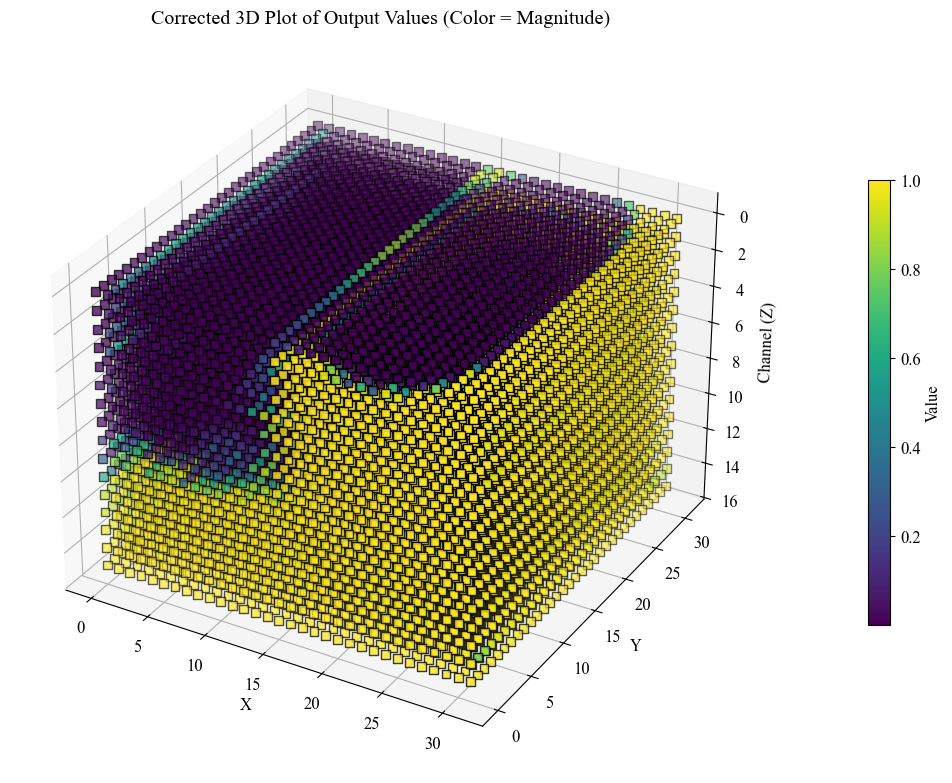

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Threshold to avoid clutter
threshold = 0
mask = output_np > threshold

# Get coordinates where value > threshold
z, y, x = np.where(mask)
values = output_np[z, y, x]

# Normalize for colormap
norm = plt.Normalize(vmin=values.min(), vmax=values.max())
colors = cm.viridis(norm(values))

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=colors, marker='s', s=40, edgecolors='k')

# Flip Z to match actual 3D volume orientation (depth at bottom)
ax.invert_zaxis()

# Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Channel (Z)')
ax.set_title('Corrected 3D Plot of Output Values (Color = Magnitude)')

# Colorbar
mappable = cm.ScalarMappable(norm=norm, cmap='viridis')
mappable.set_array(values)
cbar = plt.colorbar(mappable, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('Value')
# Set rotation angles (elevation, azimuth)
  # You can change these values to get the desired view

plt.tight_layout()
plt.show()



In [19]:
# Threshold the output: values > 0.5 become 1, else 0
binary_output = (output_np > .5).astype(np.uint8)

print("Binary output shape:", binary_output.shape)
print("Active voxels:", np.sum(binary_output))



Binary output shape: (16, 32, 32)
Active voxels: 10534


In [20]:
np.unique(binary_output)

array([0, 1], dtype=uint8)